In [1]:
import cv2
import numpy as np
import math
import matplotlib.pyplot as plt
import pytesseract
from craft_text_detector import Craft
import craft_text_detector
import shutil, os

In [2]:
from craft_text_detector import (
    read_image,
    load_craftnet_model,
    load_refinenet_model,
    get_prediction,
    export_detected_regions,
    export_extra_results,
    empty_cuda_cache
)

In [ ]:
#read 20 images to give list of 20 "image", and have list of original folders

In [9]:
#ring = cv2.imread("data/WinUSA556/Hornady556_2P_16278_H.jpg")
ring = cv2.imread("data/Hornady556/6771_FCPlain_P.jpg")
size = ring.shape[0]  # assumes square image
# Calculate from Hough circle transform
outer_radius = size // 2
inner_radius_factor = 0.5  # 0.70 measured empirically from image

In [10]:
warped = cv2.warpPolar(ring, (size, int(size * math.pi)), (outer_radius, outer_radius), outer_radius, 0)
straightened = cv2.rotate(warped, cv2.ROTATE_90_COUNTERCLOCKWISE)
cropped = straightened[: int(straightened.shape[0] * (1 - inner_radius_factor)), :]

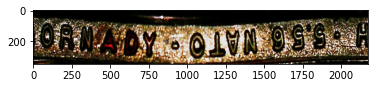

In [12]:
image = cv2.cvtColor(cropped, cv2.COLOR_BGR2RGB)
plt.imshow(image)

In [ ]:
# pull load model to front
# separate DTRB script so that load model is all at front too, in same notebook
# make functions for a) CRAFT forward pass and b) DTRB forward pass

In [ ]:
# forward pass should just be: warp, CRAFT pred, save, DTRB pred, match, print

In [13]:
# load models
refine_net = load_refinenet_model(cuda=False)
craft_net = load_craftnet_model(cuda=False)

In [ ]:
# Modify get_prediction to accept batch

In [24]:
# perform prediction
prediction_result = get_prediction(
    image=image,
    craft_net=craft_net,
    refine_net=refine_net,
    text_threshold=0.7,
    link_threshold=0.7,#0.4,
    low_text=0.4,
    cuda=False,
    long_size=1280
)

In [25]:
crops = []
for region in prediction_result["boxes"]:
    crops.append(craft_text_detector.file_utils.rectify_poly(image, region))

In [26]:
# unload models from gpu
empty_cuda_cache()

In [27]:
shutil.rmtree('temp_crops')

In [28]:
os.mkdir(os.path.join(os.getcwd(), 'temp_crops'))

In [ ]:
# save batch in sensible way

In [29]:
for i,crop in enumerate(crops):
    plt.imsave(f"temp_crops/crop_{i}.png", crop)
    plt.imsave(f"temp_crops/crop_{i}_r.png", np.flip(crop, axis=(0,1)))

In [30]:
!set CUDA_VISIBLE_DEVICES=0

In [ ]:
# output fn too

In [38]:
output = !python deep-text-recognition-benchmark/demo_func.py \
--Transformation None --FeatureExtraction ResNet --SequenceModeling None --Prediction CTC \
--image_folder temp_crops/ \
--saved_model deep-text-recognition-benchmark/None-ResNet-None-CTC.pth

In [40]:
with open("log_demo_result.txt", "r") as f:
    lines = [line[:-2].split(",") for line in f.readlines()]

In [ ]:
#split lines into list of lines for each image

In [34]:
words = []
for i in range(int(len(lines)/2)):
    [[w1, c1], [w2, c2]] = [[lines[i*2][0], float(lines[i*2][1])], [lines[i*2+1][0], float(lines[i*2+1][1])]]
    if c1 > c2:
        words += [w1]
    else:
        words += [w2]

In [ ]:
# output list of wordss for each image

In [35]:
words

['15156', 'h', 'ornady', 'nato']

In [ ]:
# make list of GTs

In [ ]:
# compare each one to all of the GTs using fuzzy matching
#return highest match
# print predictions with folder names